In [1]:
import os
import urllib   # urllib는 웹에서 데이터를 다운로드할 때 사용합니다.
import cv2      # cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요합니다.
import numpy as np
from pixellib.semantic import semantic_segmentation  
# pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리인데요

from matplotlib import pyplot as plt

print('슝=3')

슝=3


아직 시맨틱 세그멘테이션 모델을 직접 만들기에는 어려우니 이번에는 준비된 모델을 사용만 해봅니다.

준비한 이미지를 읽습니다. 각자 업로드한 이미지 파일명까지 정확하게 입력되었는지 확인해 주세요.

(3024, 4032, 3)


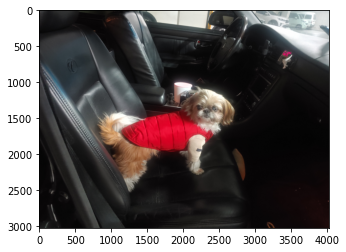

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 7-3. 셸로우 포커스 만들기 

### (2) 세그멘테이션으로 분리하기

### 세그멘테이션(Segmentation)이 뭔가요?

이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation) 이라고 합니다.

'이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정합니다. 

이때 공통 특징은 물리적 의미가 없을 수도 있습니다. 

픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠. 

물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출합니다.

### 시맨틱 세그멘테이션(semantic segmentation)이란?

세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션 이라고 합니다. 

쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해하시면 됩니다. 

오늘 다룰 세그멘테이션 방법이기도 하죠.

#### 인스턴스 세그멘테이션(Instance segmentation)이란?

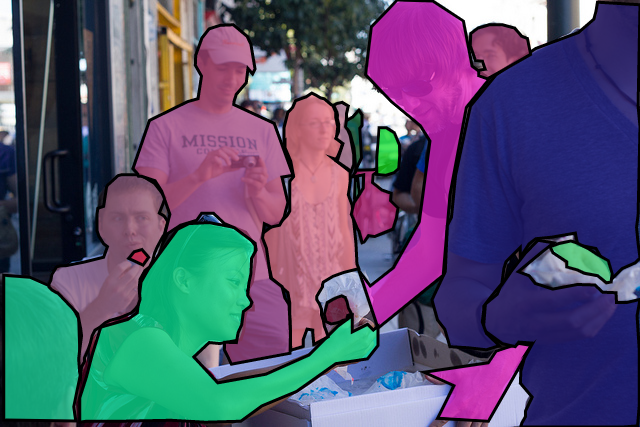

시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해 내는 방법입니다. 

그래서 사람이 누구인지 관계없이 같은 라벨로 표현이 됩니다.

더 나아가서 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨을 가지게 합니다. 

여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표입니다.

### 딥러닝에 기반한 방법 이전에는 어떻게 이미지 세그멘테이션을 했을까?

### 워터쉐드 세그멘테이션(watershed segmentation)

이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것입니다. 

그럼 경계는 어떻게 나눌 수 있을까요?



이미지는 그레이스케일(grayscale)로 변환하면 0~255의 값을 가집니다. 

픽셀 값을 이용해서 각 위치의 높고 낮음을 구분할 수 있습니다. 

낮은 부분부터 서서히 '물'을 채워 나간다고 생각하면 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생기게 됩니다. 

그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게 됩니다.

# 7-4. 셸로우 포커스 만들기 
### (3) 시맨틱 세그멘테이션 다뤄보기

본격적으로 세그멘테이션을 다루어 보겠습니다. 

세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용됩니다. 

오늘은 그중에서 DeepLab이라는 세그멘테이션 모델을 이용해 볼 건데요. 

DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있습니다.





오늘은 네트워크에 대한 자세한 설명보다 세그멘테이션의 활용 방법 위주로 다루겠습니다.

DeepLab 모델을 준비하겠습니다. 아까 준비한 PixelLib를 이용하면 편하게 사용할 수 있습니다.

먼저 PixelLib에서 제공해 주는 모델을 다운로드합니다.

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fe37c0874c0>)

그다음 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성합니다.



In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

이제 모델에 이미지를 입력해 볼게요.

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

segmentAsPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있는데요. 

PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미입니다. 

모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요합니다.

PASCAL VOC 데이터의 라벨 종류는 아래와 같습니다.

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있습니다. 따라서 20 의 의미는 tv 가 되겠네요! 0부터 시작하니까요.

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 이제 사람만 어떻게 추출할 수 있을지 알아봅시다.

아까 모델에서 나온 출력값을 살짝 살펴볼게요.



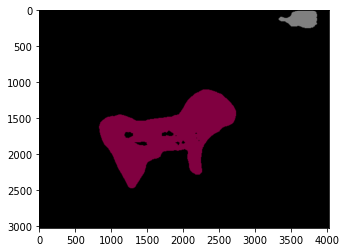

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0,  7, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
car
dog


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있네요.

segvalues에는 class_ids와 masks가 있습니다. 

class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있군요!

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같습니다.

In [10]:
# 아레 코드를 이해하지 않아도 좋스빈다.
# PixelLib에서 그대로 가져온 코드입니다.
# 주목해야 할 것은 생성 코드 결과물이에요!

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>=3
    
colormap[:20]


array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

PixelLib에 따르면 위와 같은 색을 사용했다고 하네요. 그럼 사람을 나타내는 15번째 색상은 무엇일까요?



In [11]:
colormap[12]

array([ 64,   0, 128])

사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 찾아낼 수 있겠네요!

여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이에요. colormap은 RGB 순서이고요.

그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.

In [12]:
seg_color = (128, 0, 64)

(3024, 4032)


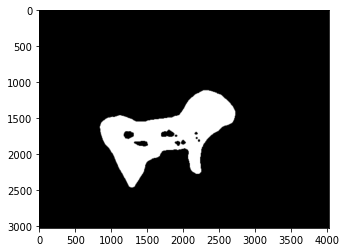

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같아면 1(True), 다르다면 0(False)이 됩니다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

어떤가요? 3채널 가졌던 원본과는 다르게 채널 정보가 사라졌습니다.

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었습니다.

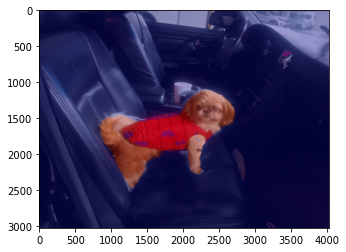

In [14]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 7-5. 셸로우 포커스 만들기 

### (4) 배경 흐리게 하기

이번에는 배경을 흐리게 만듭니다. blur() 함수를 이용합니다.

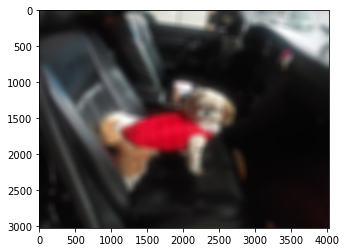

In [15]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (100, 100))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.

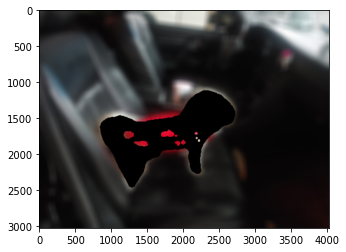

In [16]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전됩니다. 원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 되겠죠?

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다. 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지게 되는 거죠.

# 7-6. 셸로우 포커스 만들기 

### (5) 흐린 배경과 원본 영상 합성

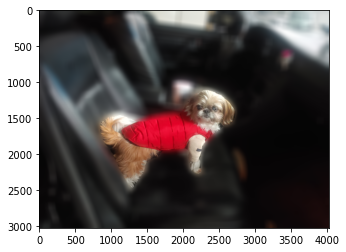

In [17]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다. np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용했네요.

인물모드가 완성되었습니다. 원본과 비교해 볼까요?

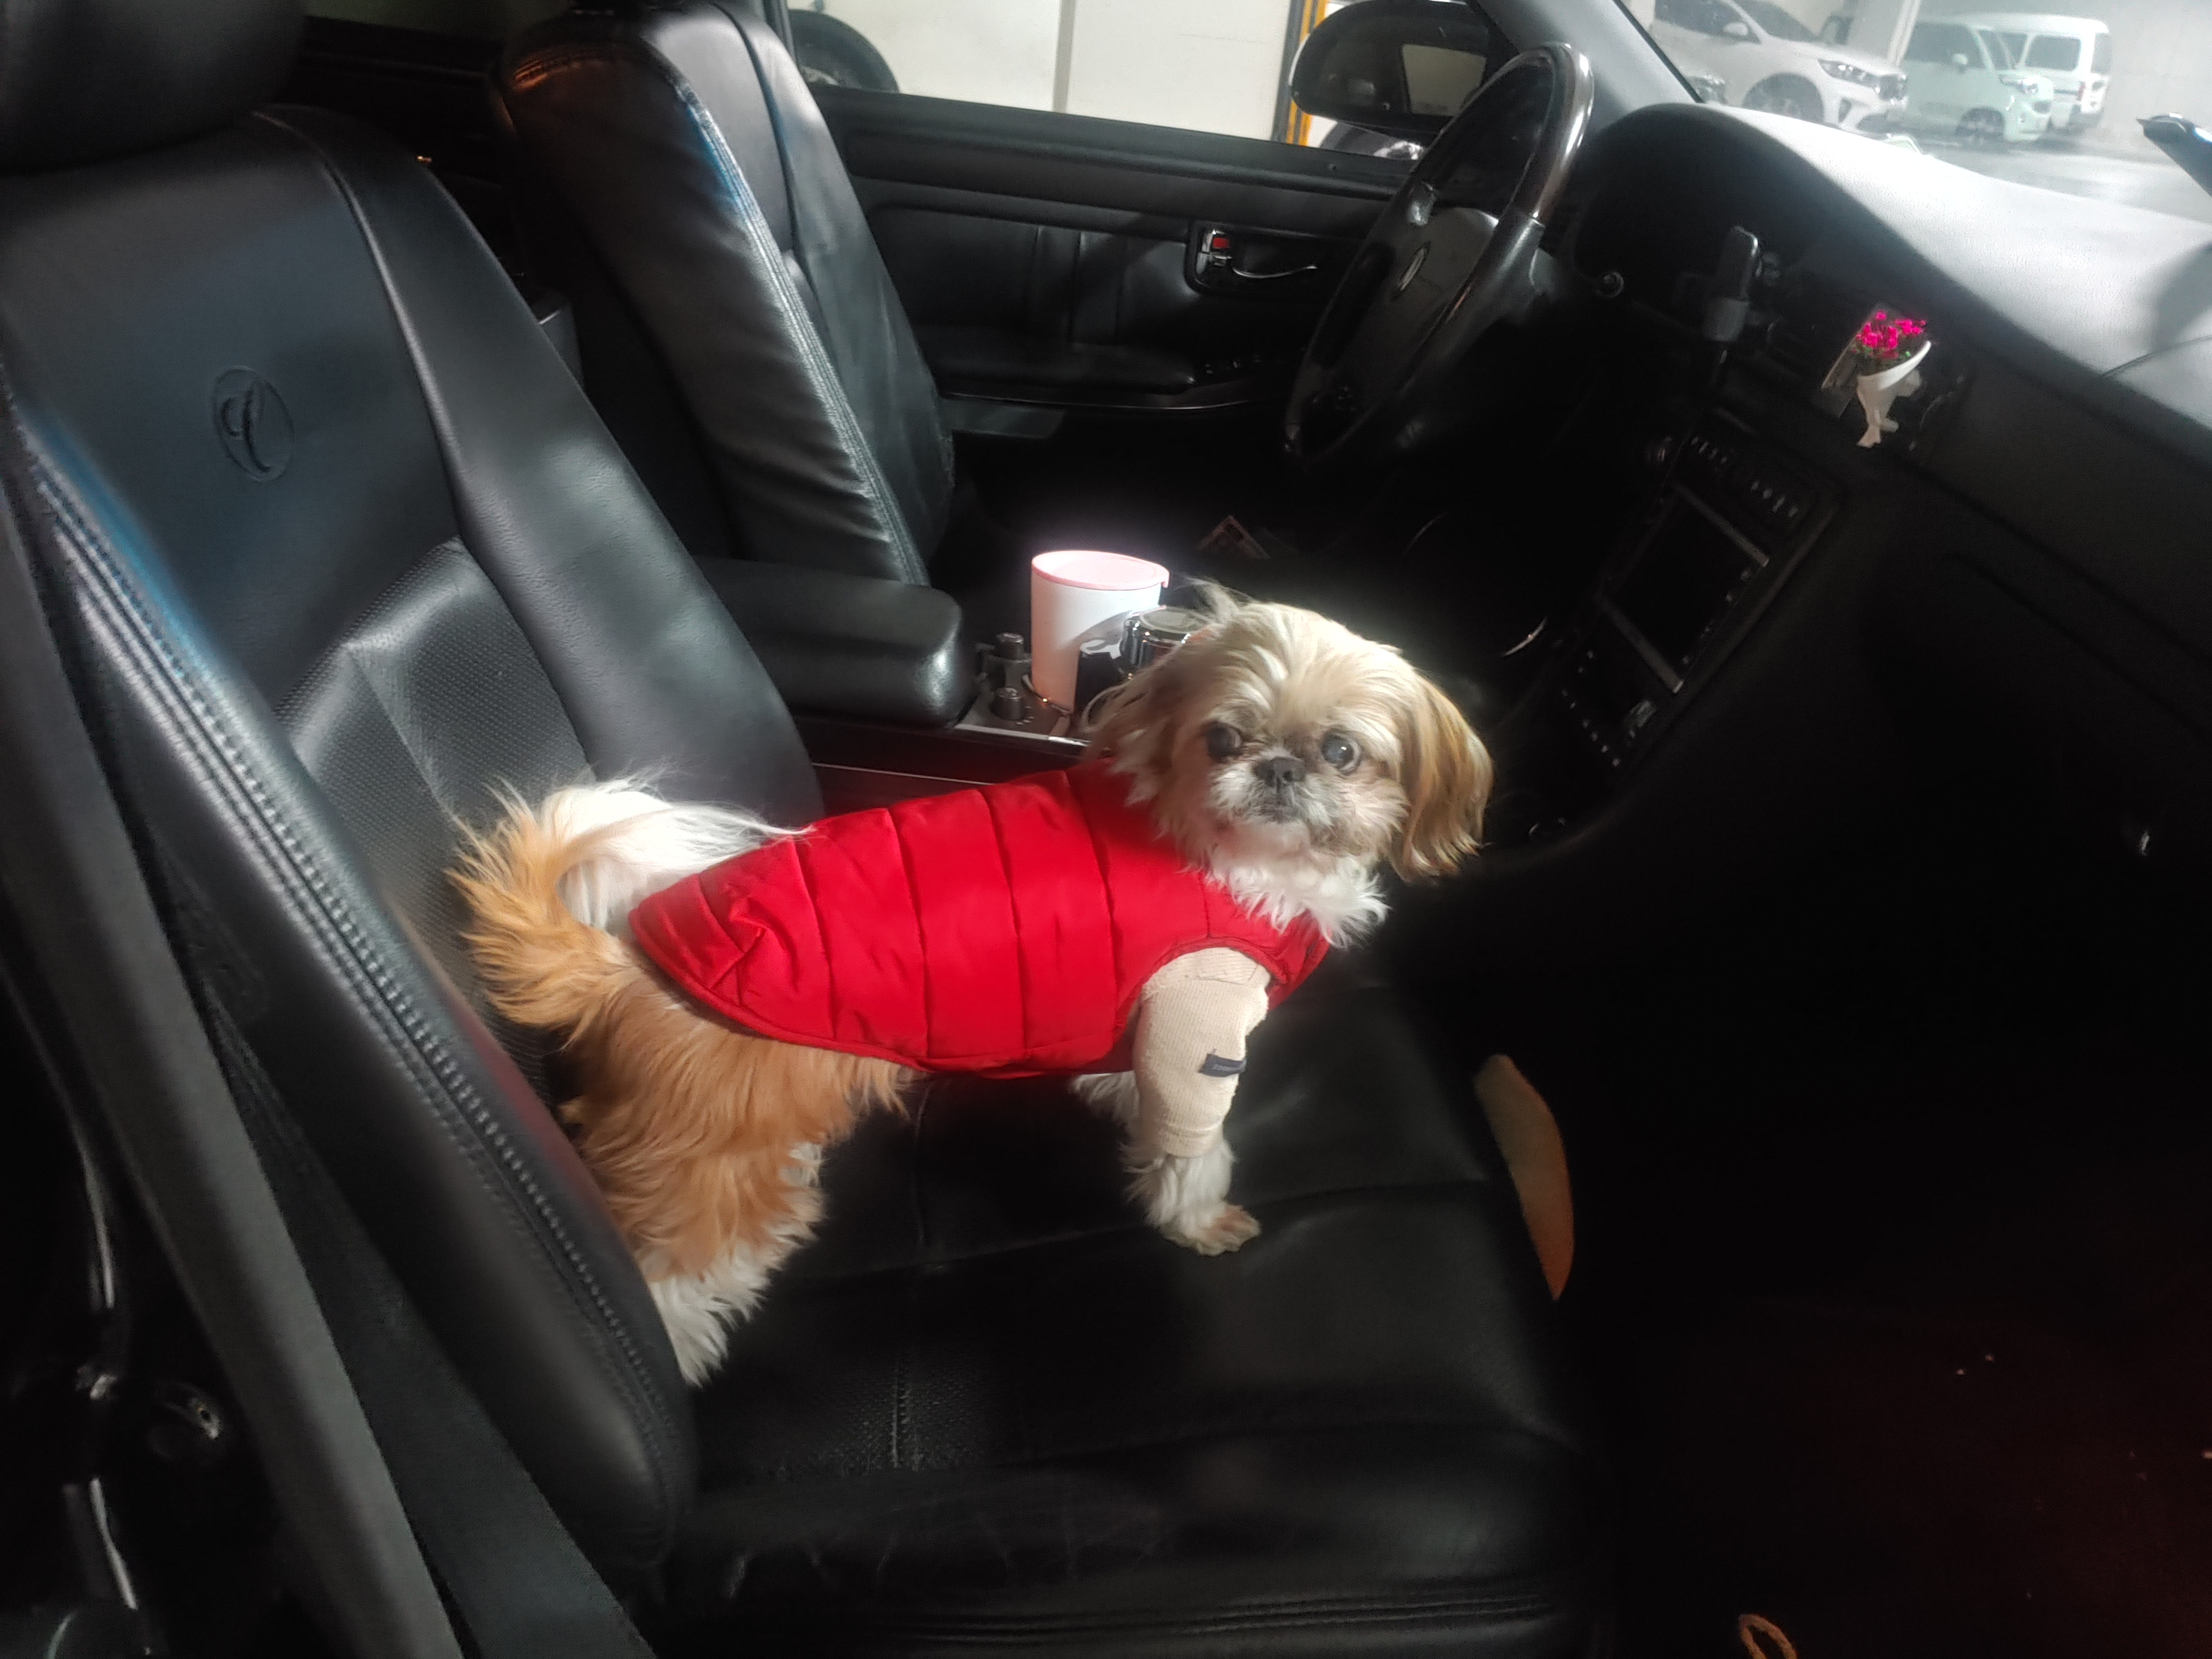

# 7-7. 프로젝트: 인물 모드 문제점 찾기

### 만들면서 뭔가 이상한 점이 느껴지지 않으셨나요? 프로젝트를 통해 찾아봅시다.

## Step 1. 인물모드 직접 해 보기

- 최소 3장 이상의 인물모드 사진을 만들어 봅시다.

- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다.

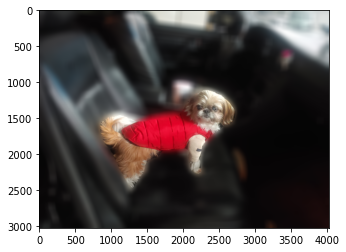

In [18]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

(1920, 4032, 3)


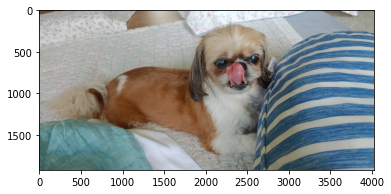

In [43]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.png'  
img_orig2 = cv2.imread(img_path2) 

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
segvalues2, output2 = model.segmentAsPascalvoc(img_path2)

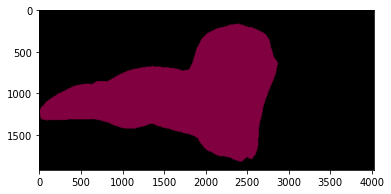

In [21]:
plt.imshow(output2)
plt.show()

In [22]:
segvalues2

{'class_ids': array([ 0, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [23]:
for class_id in segvalues2['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [24]:
# 아레 코드를 이해하지 않아도 좋스빈다.
# PixelLib에서 그대로 가져온 코드입니다.
# 주목해야 할 것은 생성 코드 결과물이에요!

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>=3
    
colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [25]:
colormap[12]

array([ 64,   0, 128])

In [26]:
seg_color = (128, 0, 64)

(1920, 4032)


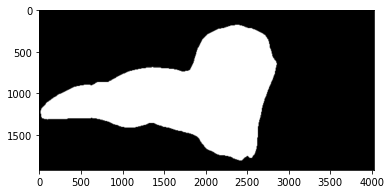

In [27]:
# output의 픽셀 별로 색상이 seg_color와 같아면 1(True), 다르다면 0(False)이 됩니다.
seg_map = np.all(output2==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

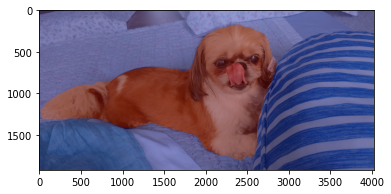

In [28]:
img_show2 = img_orig2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

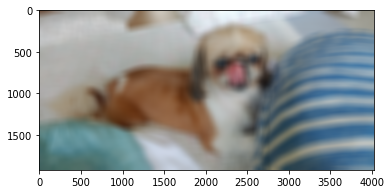

In [29]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig2_blur = cv2.blur(img_orig2, (100, 100))  
plt.imshow(cv2.cvtColor(img_orig2_blur, cv2.COLOR_BGR2RGB))
plt.show()

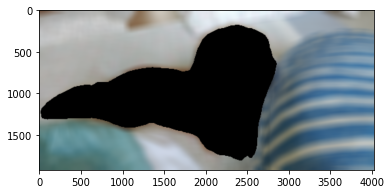

In [30]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig2_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

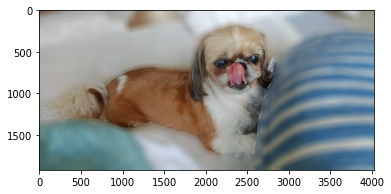

In [31]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

(4032, 3024, 3)


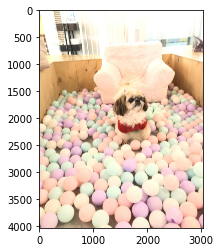

In [42]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image3.png'  
img_orig3 = cv2.imread(img_path3) 

print(img_orig3.shape)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

In [44]:
segvalues3, output3 = model.segmentAsPascalvoc(img_path3)

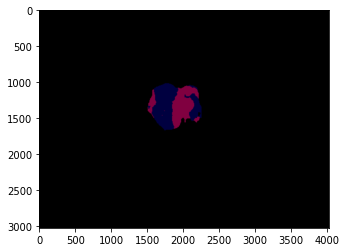

In [46]:
plt.imshow(output3)
plt.show()

In [47]:
segvalues3

{'class_ids': array([ 0,  8, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [49]:
for class_id in segvalues3['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
dog


In [50]:
# 아레 코드를 이해하지 않아도 좋스빈다.
# PixelLib에서 그대로 가져온 코드입니다.
# 주목해야 할 것은 생성 코드 결과물이에요!

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>=3
    
colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [51]:
colormap[12]

array([ 64,   0, 128])

In [52]:
seg_color = (128, 0, 64)

(3024, 4032)


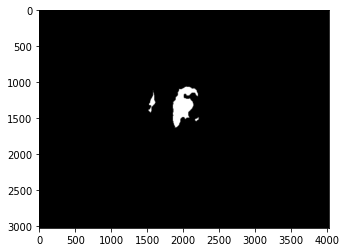

In [53]:
# output의 픽셀 별로 색상이 seg_color와 같아면 1(True), 다르다면 0(False)이 됩니다.
seg_map = np.all(output3==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

In [54]:
img_show3 = img_orig3.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show3 = cv2.addWeighted(img_show3, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))
plt.show()

error: OpenCV(4.5.3) /tmp/pip-req-build-agffqapq/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


# ※오류 발생!!!!!!※

(534, 450, 3)


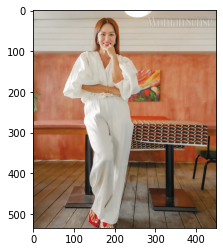

In [61]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image4.png'  
img_orig4 = cv2.imread(img_path4) 

print(img_orig4.shape)
plt.imshow(cv2.cvtColor(img_orig4, cv2.COLOR_BGR2RGB))
plt.show()

In [62]:
segvalues4, output4 = model.segmentAsPascalvoc(img_path4)

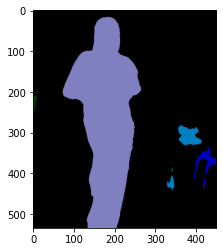

In [63]:
plt.imshow(output4)
plt.show()

In [64]:
segvalues4

{'class_ids': array([ 0,  9, 11, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [65]:
for class_id in segvalues4['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
diningtable
person
pottedplant


In [66]:
# 아레 코드를 이해하지 않아도 좋스빈다.
# PixelLib에서 그대로 가져온 코드입니다.
# 주목해야 할 것은 생성 코드 결과물이에요!

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>=3
    
colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [67]:
colormap[15]

array([192, 128, 128])

In [72]:
seg_color = (128, 128, 192)

(534, 450)


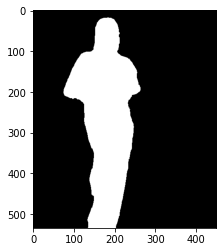

In [73]:
# output의 픽셀 별로 색상이 seg_color와 같아면 1(True), 다르다면 0(False)이 됩니다.
seg_map = np.all(output4==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

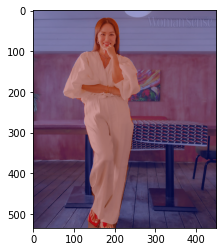

In [74]:
img_show4 = img_orig4.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show4 = cv2.addWeighted(img_show4, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
plt.show()

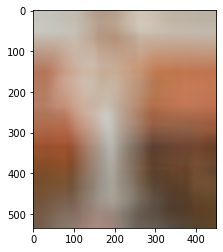

In [89]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig4_blur = cv2.blur(img_orig4, (100, 100))  
plt.imshow(cv2.cvtColor(img_orig4_blur, cv2.COLOR_BGR2RGB))
plt.show()

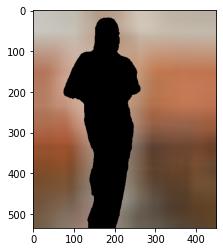

In [90]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig4_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

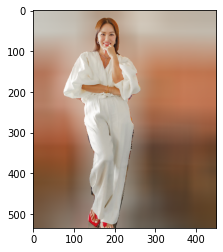

In [91]:
img_concat = np.where(img_mask_color==255, img_orig4, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2. 사진에서 문제점 찾기

위의 코드를 따라 내려가다보면 my_image3 부분에서 마스크를 사용하는 코드에서 갑자기 오류가 뜨는 것을 볼 수 있다...

원인을 찾기 위해 윗코드를 살펴보던 중

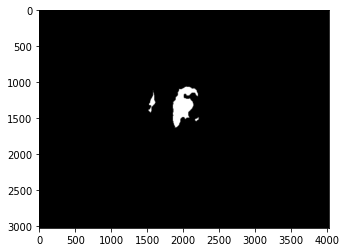

중간 결과가 이렇게 나온 것을 보아 segmentation이 잘 안된 것으로 판단된다.

강아지로 인식한 부분이 분리되어 나온 것이 화근인 것으로 보인다.
segmentation이 잘 안된 이유로는, 피사체의 크기가 너무 작거나, 조명이 너무 밝아 배경과의 구분이 어려움 등이 있을 수 있다.

## Step 3. 해결 방법을 제안해 보기

- 색상 대비를 한다.
예를들어 밝은 옷을 입고 있으면 어두운 배경 앞에, 어두운 옷을 입고 있으면 밝은 배경 앞에 선다.


- 또한 질감의 대비도 좋은 대책이다.
예를들어 평범한 티셔츠를 입고 있는 경우, 목재로 되어있는 배경 앞에 서면 더더욱 대비를 두드러지게 하여 퀄리티 높은 최종 이미지를 출력할 수 있다.

 
- 거리를 유지해야 한다.
인물 사진 모드는 피사체가 4~6피트 거리에 있을 때 가장 잘 작동한다고 한다. 그 스위트 스폿을 벗어나면 피사체를 배경과 분리하는 데 사용되는 기술이 제대로 작동하지 않는다고 한다.
피사체와 배경 사이의 거리가 훨씬 더 중요하다. 둘 사이의 물리적 간격이 클수록 휴대전화가 깊이를 정확하게 측정하고 더 나은 사진을 찍기가 더 쉬워진다..


- 그늘과 창문 사용
인물 사진의 경우 외부 그늘(나무 아래 또는 골목)이나 큰 창을 통해 들어오는 가장 좋은 빛을 찾을 수 있습니다. 두 설정 모두 훌륭하고 아첨하는 부드러운 빛을 제공하여 피사체가 잘 보이도록 충분한 선명도를 제공합니다. 반면에 직사광선과 같은 단단한 빛은 특히 사람의 얼굴에 불쾌하고 거친 그림자를 만듭니다. 피사체를 그늘진 곳에 두거나 창을 바라보면 크게 잘못될 일이 없습니다.